In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
sns.set(style="darkgrid")

# Exploratory Data Analysis

In [4]:
df = pd.read_csv("day.csv")

In [8]:
df.shape

(730, 16)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [12]:
# except for `dteday`, everything else is numerical (int/float)

In [14]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Null Check

In [17]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [19]:
# There are no null objects. Lets analyse each columns in detail

## Check (Casual + Registered != Cnt)

In [22]:
df[df["casual"]+df["registered"] != df["cnt"]]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [24]:
# Empty - so data looks good.

## Drop non-required Columns 

In [27]:
# Based on the data dictionary
# `instant` is just an index which is not required in the modeling exercise
# since `cnt` is the target variable which depends on `casual` and `registered`, we can also ignore these two fields in model building

# Remove `instant`, `casual` and `registered`
df_updated = df.drop(columns=["instant", "casual", "registered"])
df_updated.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [29]:
df_updated.shape

(730, 13)

## Data Modification

In [32]:
#The only variable that needs modification now is `dteday` which needs to be converted into datetime obj

df_updated["dteday"] = pd.to_datetime(df_updated["dteday"], format="%d-%m-%Y")
df_updated["dteday"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 730 entries, 0 to 729
Series name: dteday
Non-Null Count  Dtype         
--------------  -----         
730 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 5.8 KB


## Categorical Analysis

In [35]:
# Following are the categorical variables
# ['season', 'mnth', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']

### Analyse yr

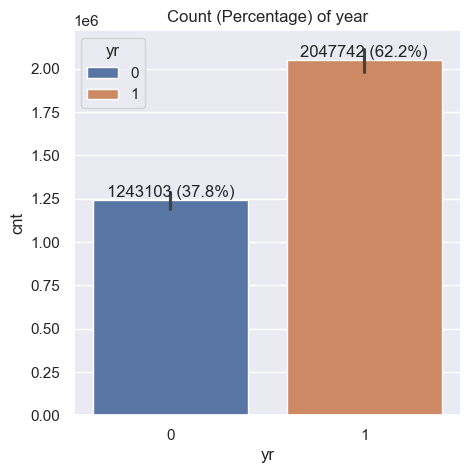

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
plt.title("Count (Percentage) of year")
ax = sns.barplot(data=df_updated, x="yr", hue="yr", y="cnt",  legend="full", estimator="sum")
ax.tick_params(axis="x")
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')
plt.show()

In [40]:
# The year should be a continuous variable in general. 
# But since we have only data related to 2 years, we are including this as part of categorical variables.

# We can see a growing trend from 2018 to 2019.

### Analyse season

In [43]:
df_updated.season.value_counts()

season
3    188
2    184
1    180
4    178
Name: count, dtype: int64

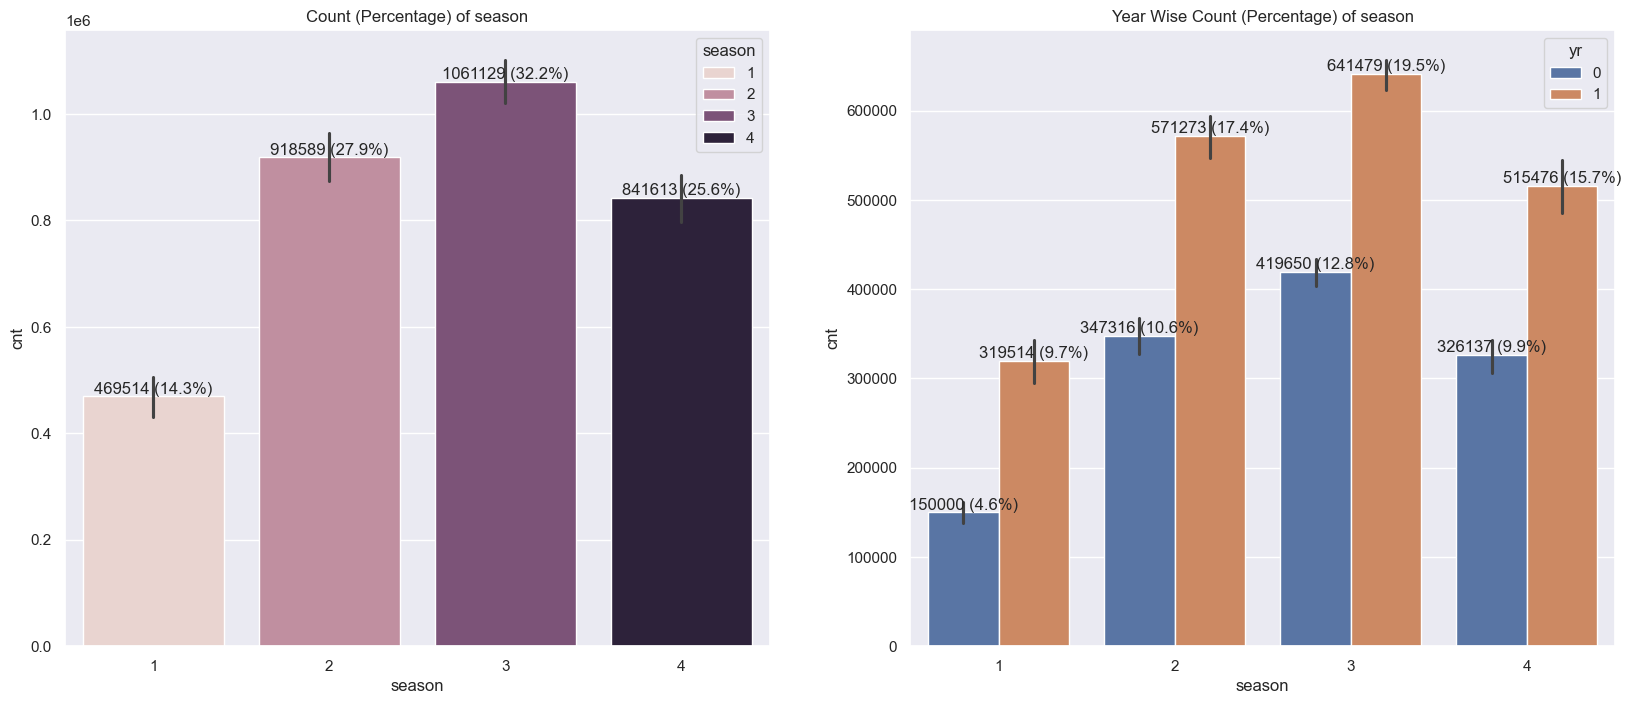

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axs[0].set_title("Count (Percentage) of season")
axs[1].set_title("Year Wise Count (Percentage) of season")
sns.barplot(data=df_updated, x="season", hue="season", y="cnt",  legend="full", estimator="sum", ax=axs[0])
ax.tick_params(axis="x")
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')
sns.barplot(data=df_updated, x="season", hue="yr", y="cnt",  legend="full", estimator="sum", ax=axs[1])
ax.tick_params(axis="x")
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')
plt.show()

In [47]:
# Clearly we can see the `1` (which corresponds to spring) has least demand for bikes but rest of the 3 seasons have fairly good demand with peak being in season `3` in both the years.

### Analyse mnth

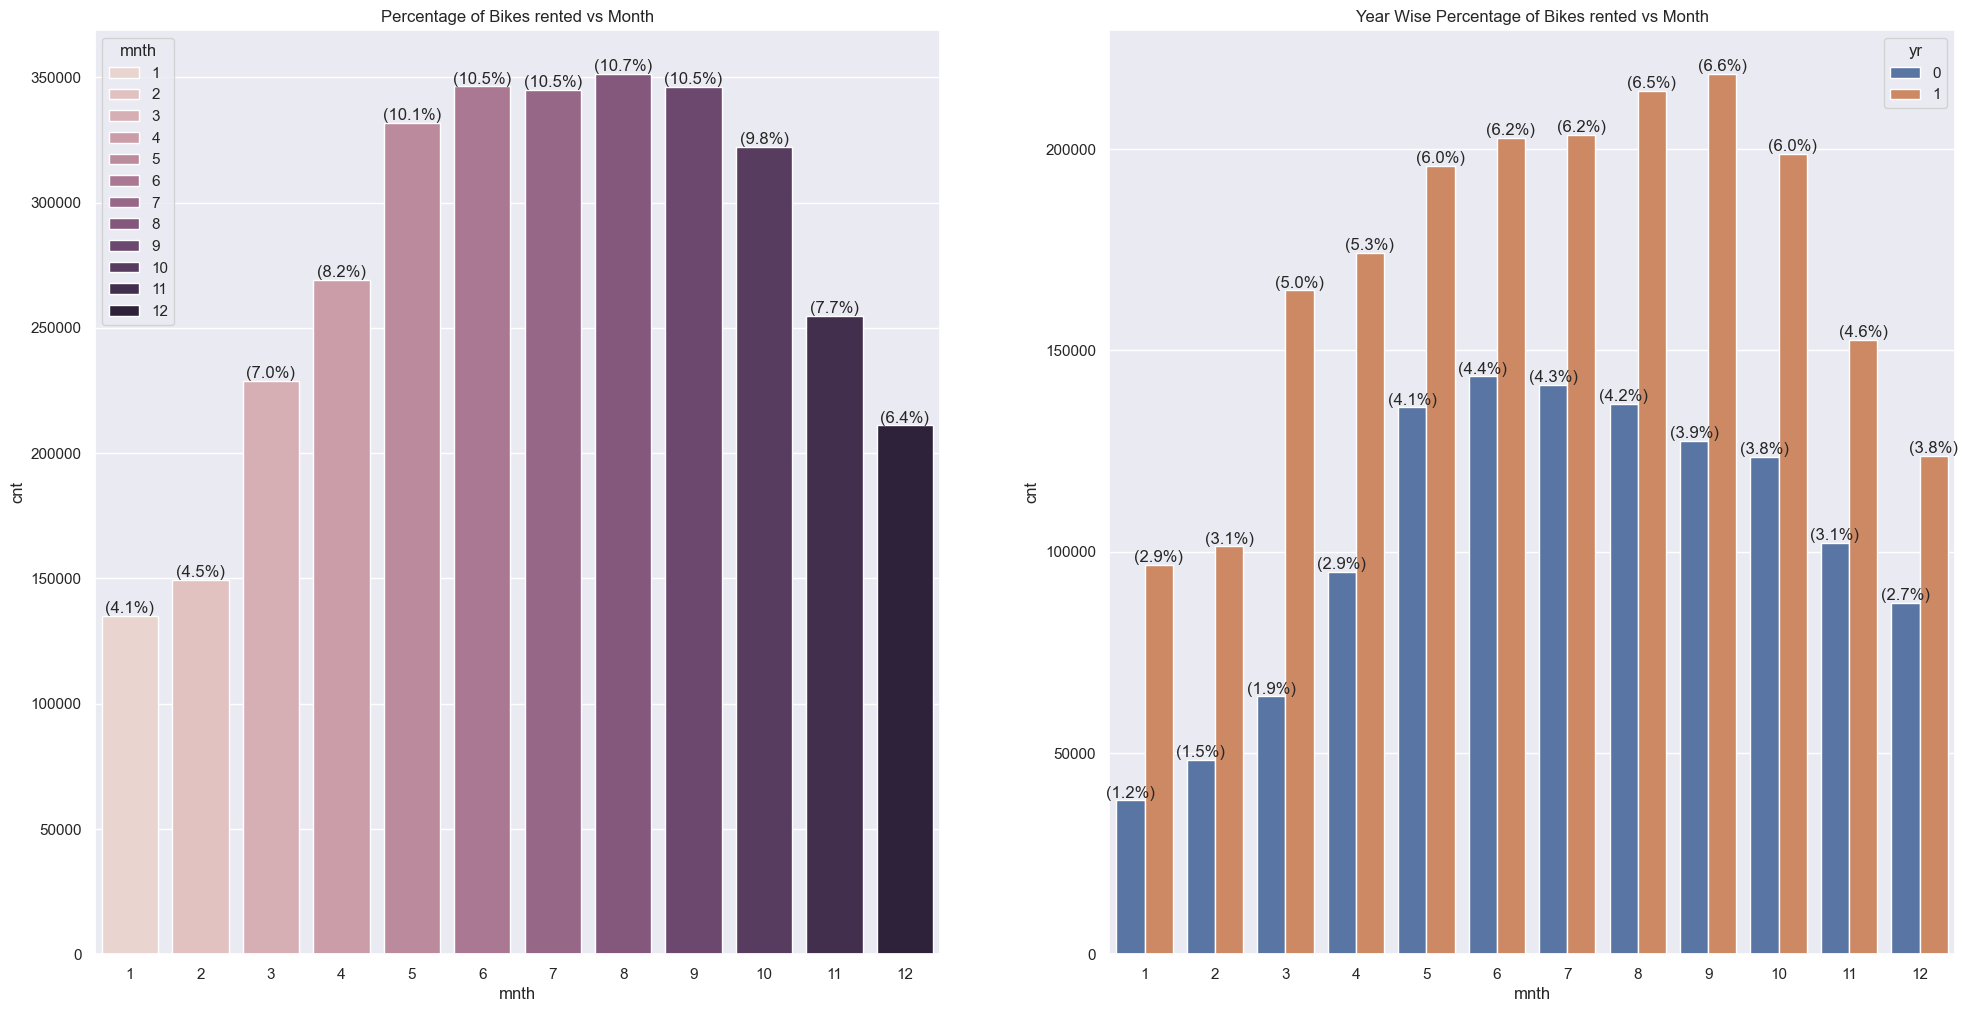

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
axs[0].set_title("Percentage of Bikes rented vs Month")
axs[1].set_title("Year Wise Percentage of Bikes rented vs Month")
sns.barplot(data=df_updated, x="mnth", hue="mnth", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[0])
axs[0].tick_params(axis="x")
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'({x/df_updated.cnt.sum()*100:0.1f}%)')
sns.barplot(data=df_updated, x="mnth", hue="yr", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[1])
axs[1].tick_params(axis="x")
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'({x/df_updated.cnt.sum()*100:0.1f}%)')

plt.show()

In [51]:
# This confirms the analysis of `season`. Jan/Feb (1/2) months seems to have very less demand for Bikes (in both the years as well)
# We can expect high colinearity between `season` and `mnth`. But will keep it for later analysis

### Analyse weekday

In [55]:
# Check if there are any misinformation about workingday i.e having `workingday=1` when the `weekday` is either 0 or 6
df_updated[(df_updated["workingday"] == 1) & ((df_updated["weekday"] == 0) | (df_updated["weekday"] == 6))]

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt


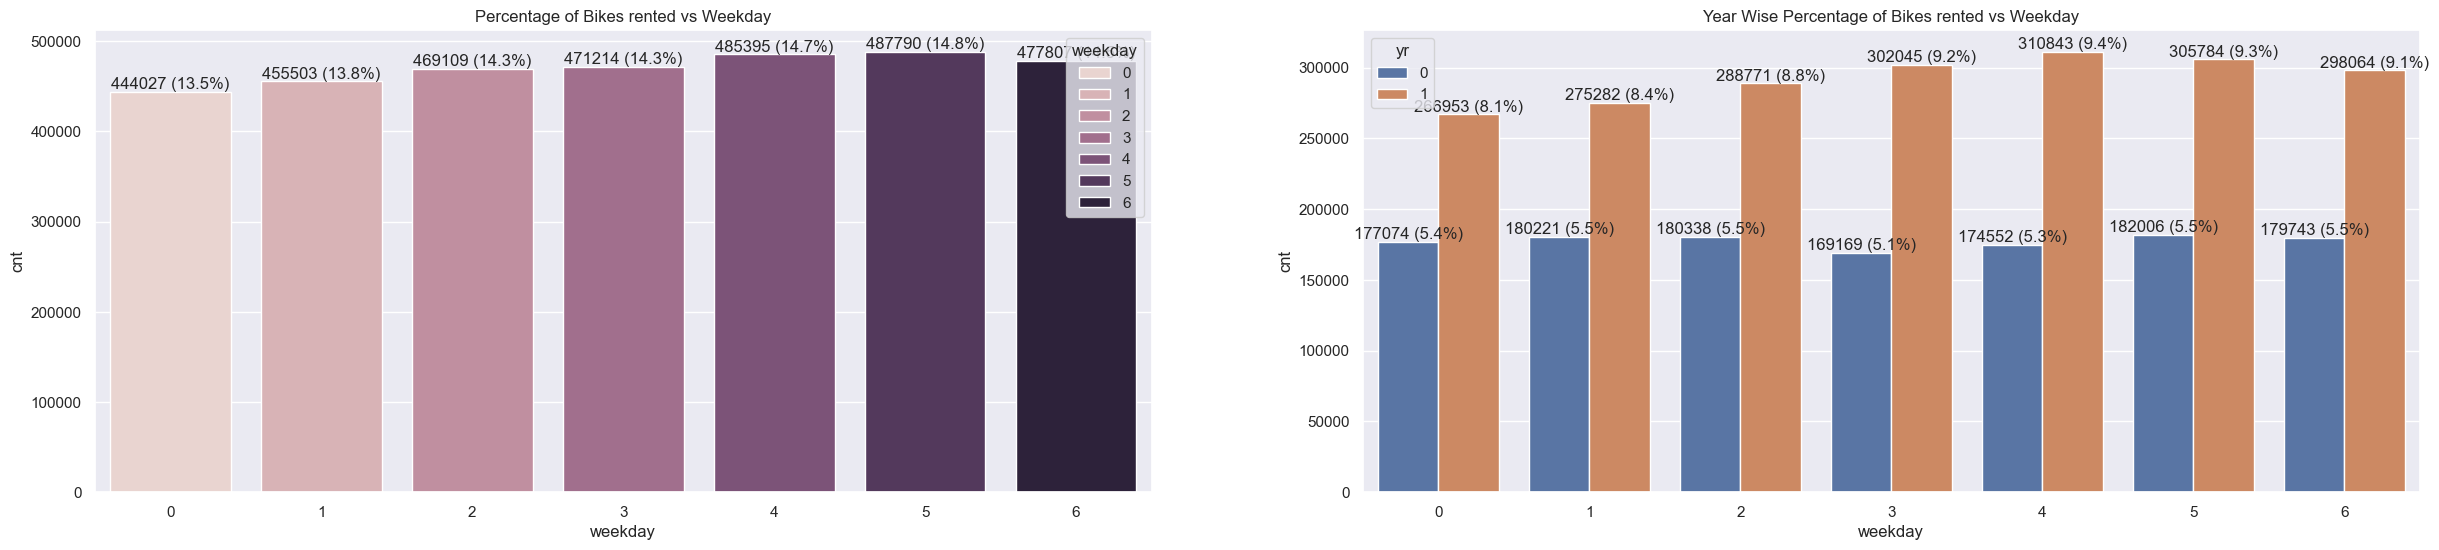

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))
axs[0].set_title("Percentage of Bikes rented vs Weekday")
axs[1].set_title("Year Wise Percentage of Bikes rented vs Weekday")
sns.barplot(data=df_updated, x="weekday", hue="weekday", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[0])
axs[0].tick_params(axis="x")
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')
sns.barplot(data=df_updated, x="weekday", hue="yr", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[1])
axs[1].tick_params(axis="x")
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')
plt.show()

In [59]:
# There is no trend in renting a bike vs weekday during both the years.

### Analyse holiday

In [62]:
df.holiday.value_counts()

holiday
0    709
1     21
Name: count, dtype: int64

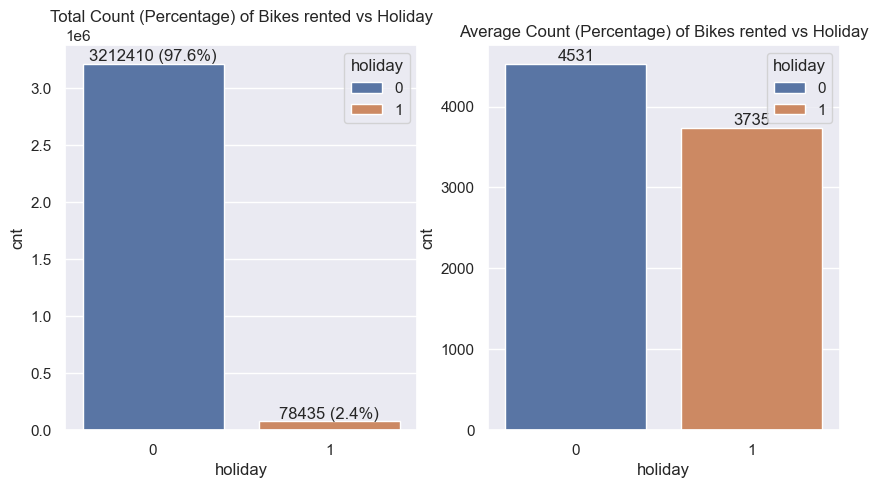

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].set_title("Total Count (Percentage) of Bikes rented vs Holiday")
axs[1].set_title("Average Count (Percentage) of Bikes rented vs Holiday")

sns.barplot(data=df_updated, x="holiday", hue="holiday", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[0])
axs[0].tick_params(axis="x")
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')

sns.barplot(data=df_updated, x="holiday", hue="holiday", y="cnt",  legend="full", errorbar=None, ax=axs[1])
axs[1].tick_params(axis="x")
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x:0.0f}')
plt.show()

In [66]:
# Most of the Bike rentals are during non-holiday days
# Also the average rentals are higher during non-holiday days

### Analyse Workingday

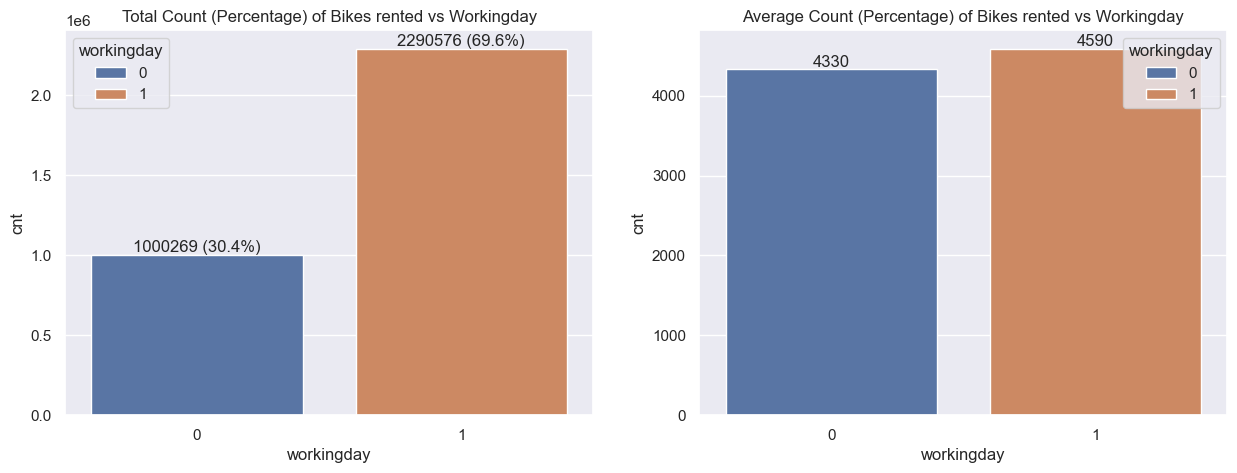

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].set_title("Total Count (Percentage) of Bikes rented vs Workingday")
axs[1].set_title("Average Count (Percentage) of Bikes rented vs Workingday")

sns.barplot(data=df_updated, x="workingday", hue="workingday", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[0])
axs[0].tick_params(axis="x")
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')

sns.barplot(data=df_updated, x="workingday", hue="workingday", y="cnt",  legend="full", errorbar=None, ax=axs[1])
axs[1].tick_params(axis="x")
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x:0.0f}')
plt.show()

In [71]:
# ~70% of total rentals are during working day.
# Average cnt of booking is also high during working day.

### Analyse weathersit

In [74]:
df_updated["weathersit"].value_counts()

weathersit
1    463
2    246
3     21
Name: count, dtype: int64

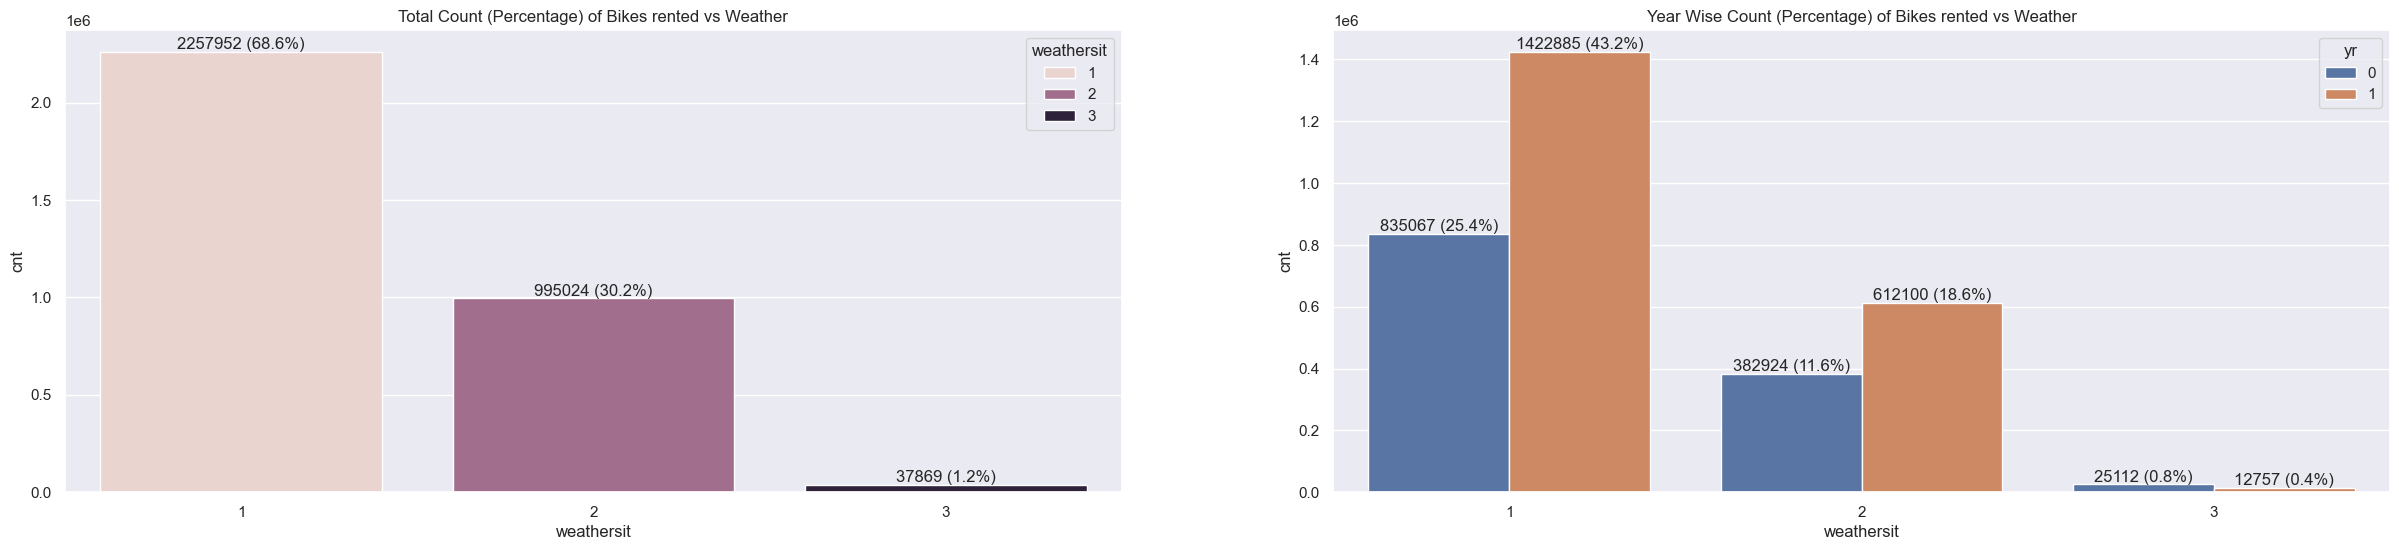

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))
axs[0].set_title("Total Count (Percentage) of Bikes rented vs Weather")
axs[1].set_title("Year Wise Count (Percentage) of Bikes rented vs Weather")
sns.barplot(data=df_updated, x="weathersit", hue="weathersit", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[0])
axs[0].tick_params(axis="x")
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')
sns.barplot(data=df_updated, x="weathersit", hue="yr", y="cnt",  legend="full", estimator="sum", errorbar=None, ax=axs[1])
axs[0].tick_params(axis="x")
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/df_updated.cnt.sum()*100:0.1f}%)')
plt.show()

In [77]:
# clearly the demand will be higher (~69%) during clear weather(`1`).
# During rainy days (`3), we have very low demand for bike rental.
# The trend is similar for both the years

## Analyse Numeric Variables

In [81]:
# Following are the numeric variables we need to analyse
# ['dteday', 'temp', 'atemp', 'hum', 'windspeed']

### Outlier analysis

In [84]:
numeric_variables = ["temp", "atemp", "hum", "windspeed"]

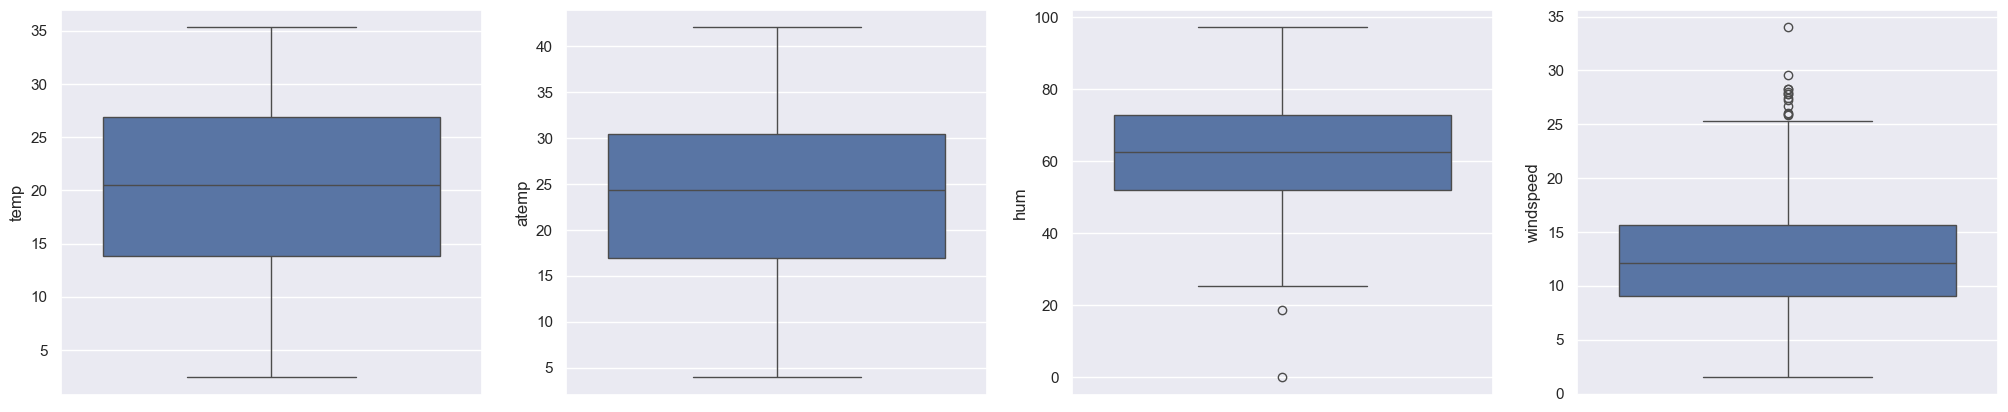

In [86]:
plt.figure(figsize=(25,5))

for idx, item in enumerate(numeric_variables):     
    plt.subplot(1, len(numeric_variables), idx+1)
    sns.boxplot(y=item, data=df_updated)
plt.show()

In [87]:
# `temp` and `atemp` has similar distribution.
# We can observe few outliers in `hum` and `windspeed` but nothing to worry about to perform outlier treatment

## Correlation Analysis

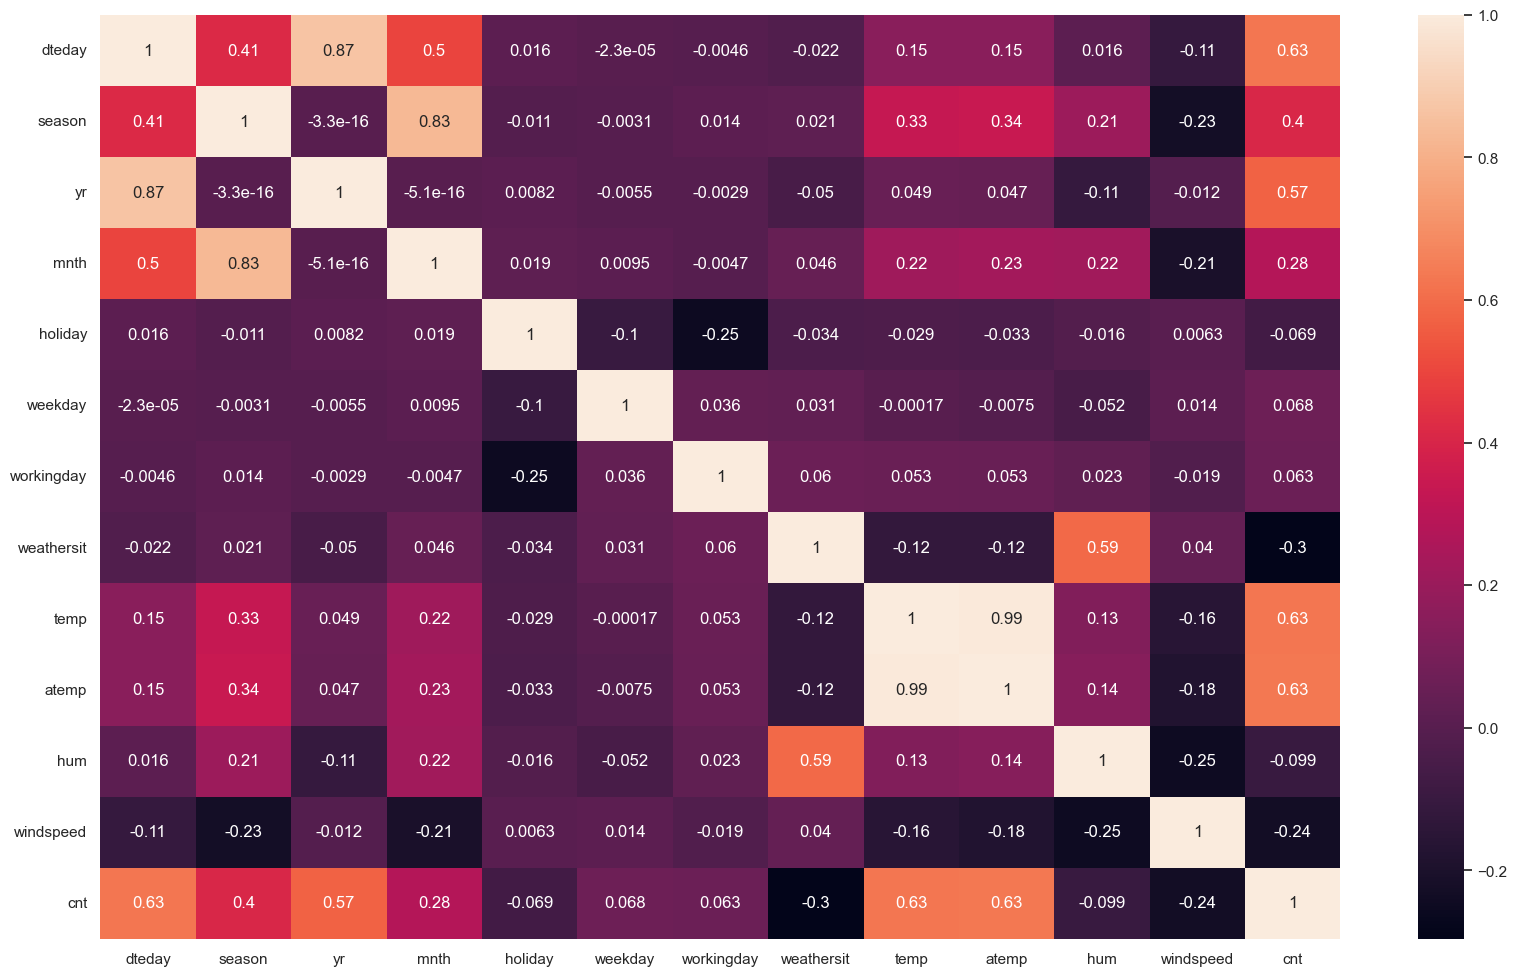

In [91]:
plt.figure(figsize=(20,12))
sns.heatmap(data=df_updated.corr(), annot=True)
plt.show()

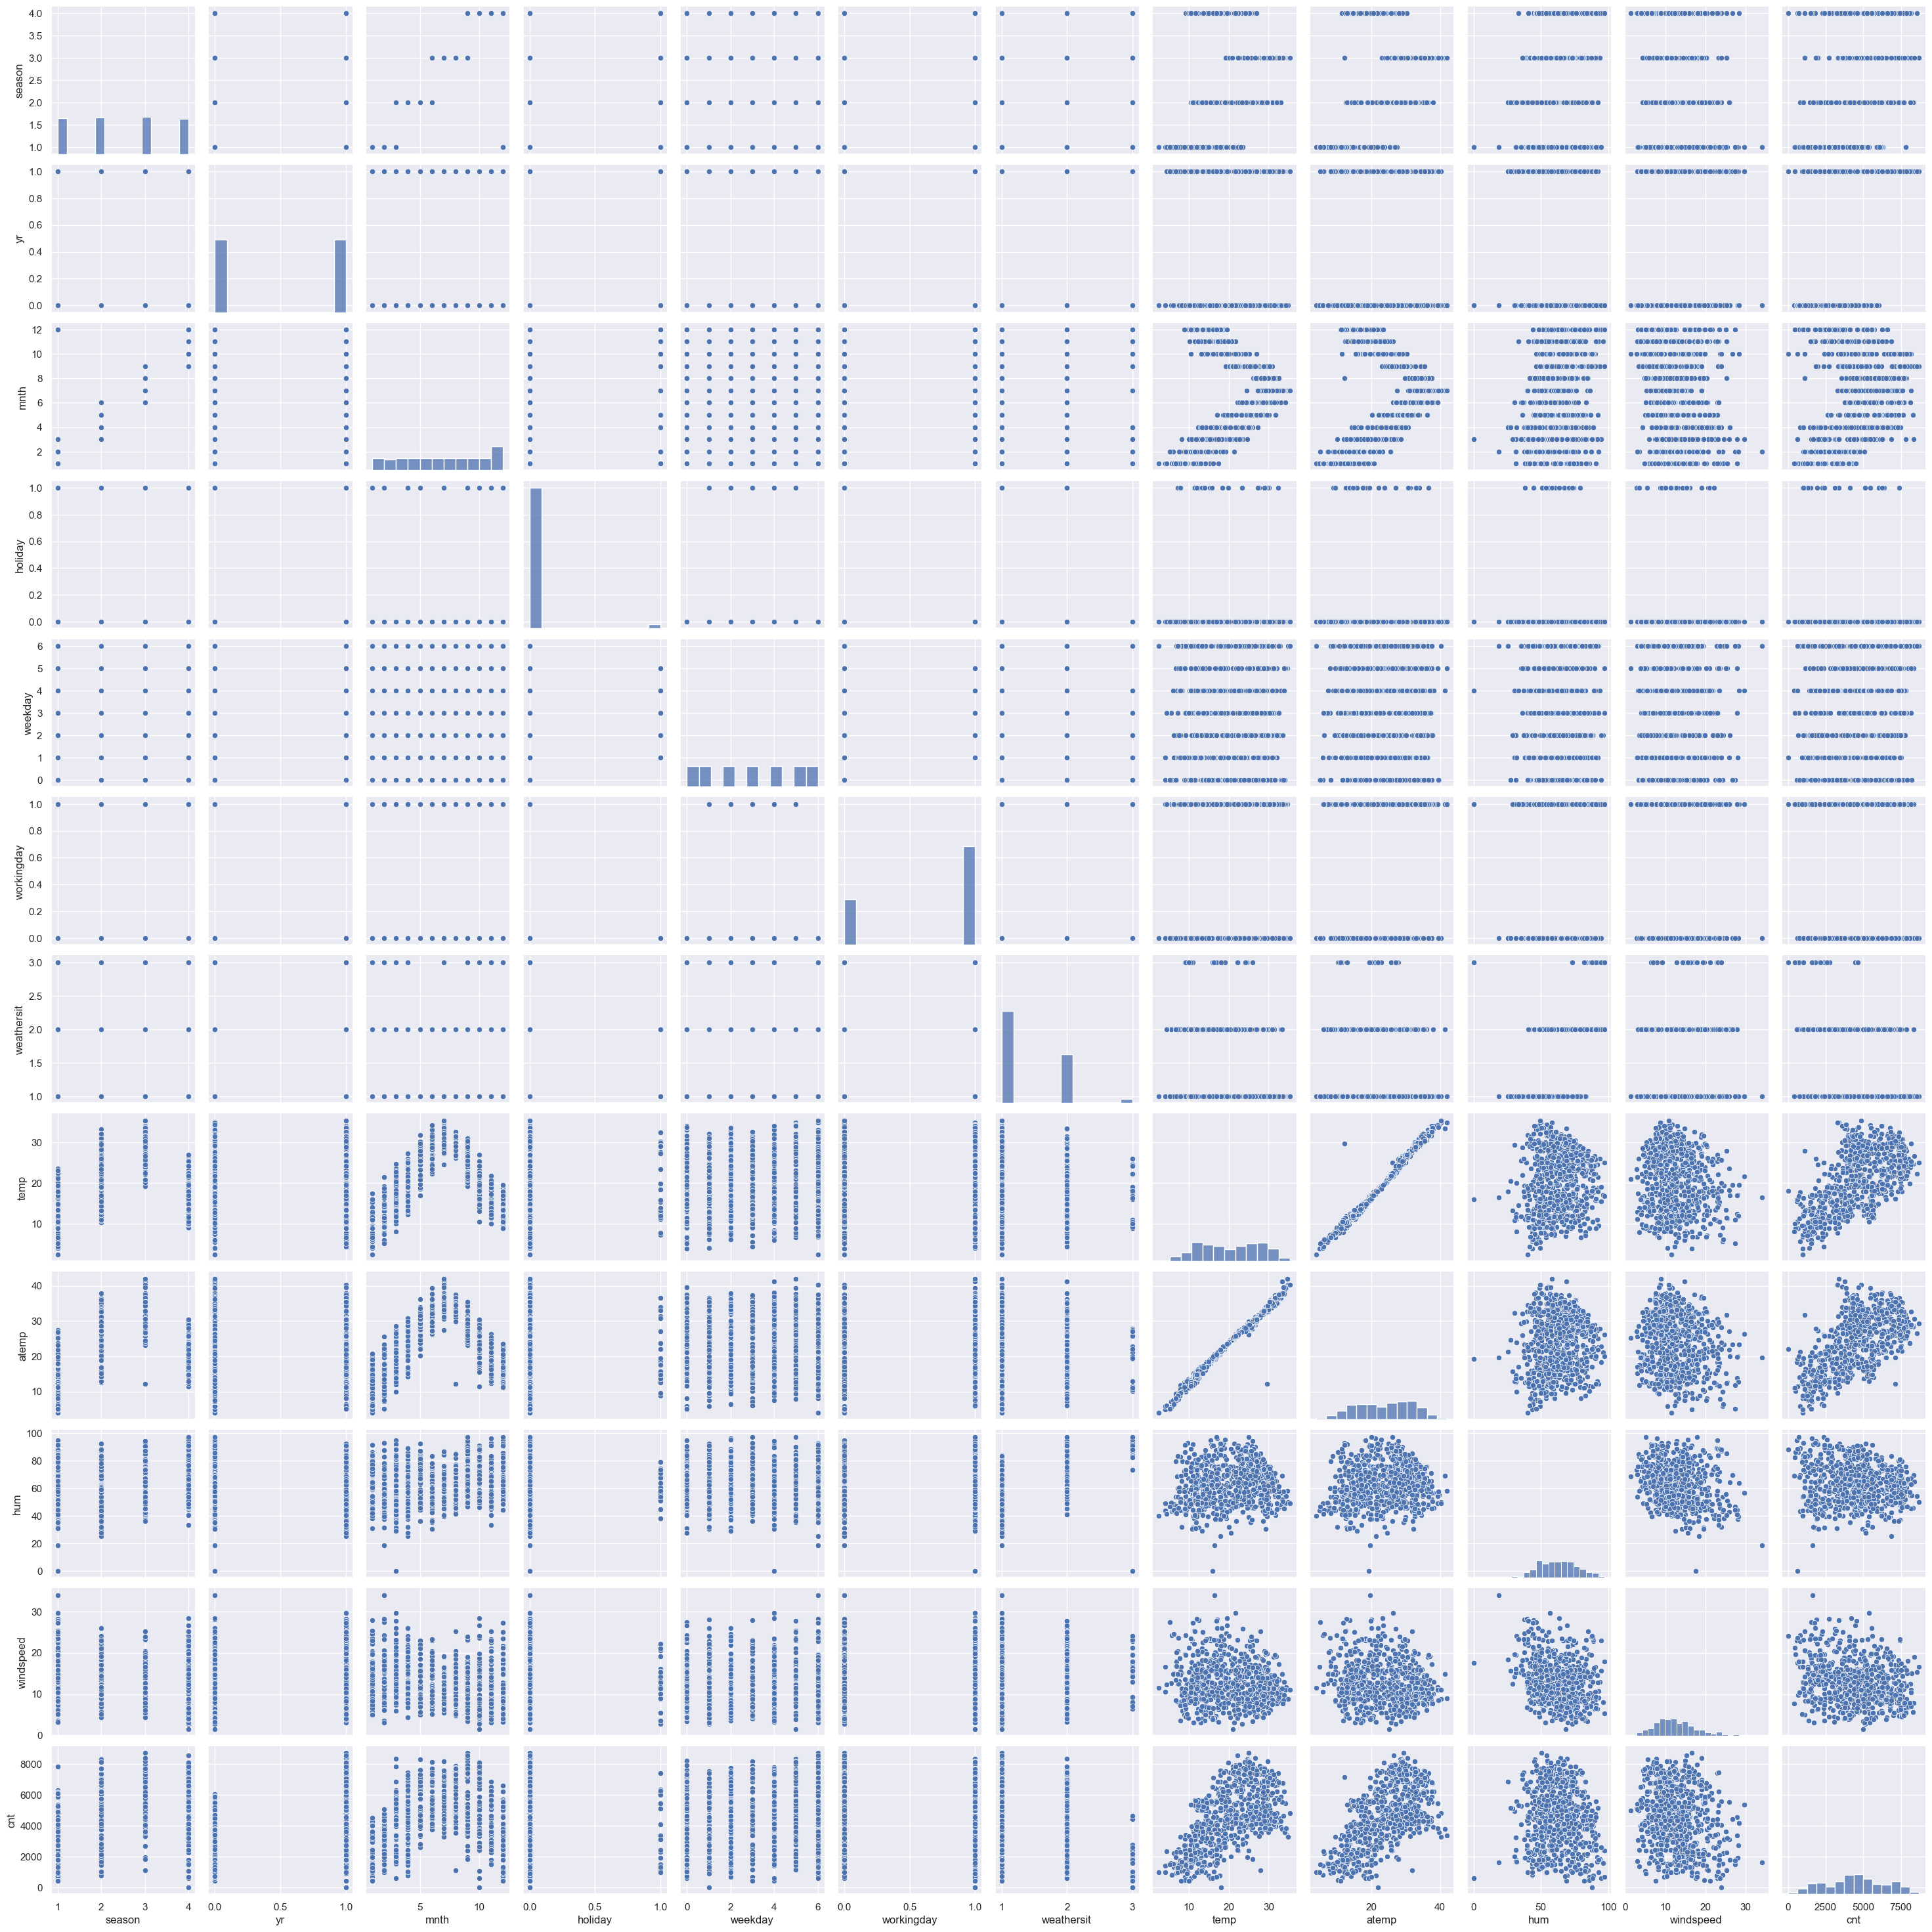

In [93]:
sns.pairplot(data=df_updated)
plt.show()

In [95]:
# Can see high correlation between 
# temp - atemp
# dteday - yr
# season - month
# temp - cnt seems to be linearly correlated

In [97]:
# Clearly we can get rid of one of `temp` or `atemp`. Lets remove `atemp`
# dteday can be easily represented by `yr`, `month` so we can drop that as well.
# regarding season and month, though we can say that month represents the season, not very sure about which one remove (if at all) 

In [99]:
df_updated = df_updated.drop(columns=["atemp", "dteday"], axis=1)

In [101]:
df_updated.shape

(730, 11)

In [103]:
df_updated.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


In [105]:
# Experiment 1 - Remove `season` and retain `month` based on the assumption that month provides granular information.

# df_updated = df_updated.drop(columns=["season"], axis=1)

# Here are the observation - 
## random_state - 100 rfe variables 15, (adj r-square - 0.784 - temp, workingday, windspeed, yr, day_Saturday, mnth_Jan, mnth_Feb, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, w_light_rain) -> RSE slightly right to 0
## random_state - 49 rfe variables 15, (adj r-square - 0.798 - temp, workingday, windspeed, yr, day_Saturday, mnth_Jan, mnth_Feb, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, w_light_rain) -> RSE 0
## random_state - 49 rfe variables 18, (adj r-square - 0.808 - temp, workingday, windspeed, yr, day_Saturday, mnth_Jan, mnth_Feb, mnth_Mar, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, mnth_Dec, w_light_rain) -> RSE slightly left to 0


# Experiment 2 - Remove `month` and retain `season`.

# df_updated = df_updated.drop(columns=["mnth"], axis=1)

# Here are the observations
## random_state - 49 rfe 15, (adj r-square - 0.807 - temp, workingday, windspeed, yr, day_Saturday, season_spring, season_summer, season_winter, w_cloudy, w_light_rain) -> RSE 0
## random_state - 100 rfe 15, (adj r-square - 0.801 - temp, workingday, windspeed, yr, day_Saturday, season_spring, season_summer, season_winter, w_cloudy, w_light_rain) -> RSE 0

# Commenting out these two experiments because in the end retaining both month and season has increased the model predictions.

# Dummy Variables

In [108]:
# We can create dummy variables for ["season", "mnth", "weathersit", "weekday"]

In [110]:
# convert numeric values to string
df_updated["season"] = df_updated["season"].replace({1:"season_spring", 2:"season_summer", 3:"season_fall", 4:"season_winter"})
df_updated["mnth"] = df_updated["mnth"].replace({1:"mnth_Jan", 2:"mnth_Feb", 3:"mnth_Mar", 4:"mnth_Apr", 5:"mnth_May", 6:"mnth_Jun", 7:"mnth_Jul", 8: "mnth_Aug", 9:"mnth_Sep", 10:"mnth_Oct", 11:"mnth_Nov", 12:"mnth_Dec"})
df_updated["weekday"] = df_updated["weekday"].replace({0: "day_Sunday", 1:"day_Monday", 2:"day_Tuesday", 3:"day_Wednesday", 4:"day_Thursday", 5:"day_Friday", 6:"day_Saturday"})
df_updated["weathersit"] = df_updated["weathersit"].replace({1:"w_clear", 2:"w_cloudy", 3:"w_light_rain", 4:"w_thunderstorm"})
df_updated.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,season_spring,0,mnth_Jan,0,day_Saturday,0,w_cloudy,14.110847,80.5833,10.749882,985
1,season_spring,0,mnth_Jan,0,day_Sunday,0,w_cloudy,14.902598,69.6087,16.652113,801
2,season_spring,0,mnth_Jan,0,day_Monday,1,w_clear,8.050924,43.7273,16.636703,1349
3,season_spring,0,mnth_Jan,0,day_Tuesday,1,w_clear,8.200000,59.0435,10.739832,1562
4,season_spring,0,mnth_Jan,0,day_Wednesday,1,w_clear,9.305237,43.6957,12.522300,1600


In [112]:
def create_dummy_variable(variable, df):
    dummy_df = pd.get_dummies(df[variable], drop_first=True,  dtype=int)
    df = pd.concat([df, dummy_df], axis=1)
    return df

In [114]:
dummy_variables = ["season", "mnth", "weathersit", "weekday"]
# dummy_variables = ["season", "weathersit", "weekday"]

df_with_dummies = df_updated
for variable in dummy_variables:
    df_with_dummies = create_dummy_variable(variable, df_with_dummies)
df_with_dummies.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,...,mnth_Oct,mnth_Sep,w_cloudy,w_light_rain,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,season_spring,0,mnth_Jan,0,day_Saturday,0,w_cloudy,14.110847,80.5833,10.749882,...,0,0,1,0,0,1,0,0,0,0
1,season_spring,0,mnth_Jan,0,day_Sunday,0,w_cloudy,14.902598,69.6087,16.652113,...,0,0,1,0,0,0,1,0,0,0
2,season_spring,0,mnth_Jan,0,day_Monday,1,w_clear,8.050924,43.7273,16.636703,...,0,0,0,0,1,0,0,0,0,0
3,season_spring,0,mnth_Jan,0,day_Tuesday,1,w_clear,8.200000,59.0435,10.739832,...,0,0,0,0,0,0,0,0,1,0
4,season_spring,0,mnth_Jan,0,day_Wednesday,1,w_clear,9.305237,43.6957,12.522300,...,0,0,0,0,0,0,0,0,0,1


In [116]:
df_with_dummies.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'cnt', 'season_spring',
       'season_summer', 'season_winter', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb',
       'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov',
       'mnth_Oct', 'mnth_Sep', 'w_cloudy', 'w_light_rain', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday'],
      dtype='object')

In [118]:
# Drop ["season", "mnth", "weathersit", "weekday"]
df_with_dummies = df_with_dummies.drop(columns=dummy_variables, axis=1)

In [120]:
df_with_dummies.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'w_cloudy',
       'w_light_rain', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday'],
      dtype='object')

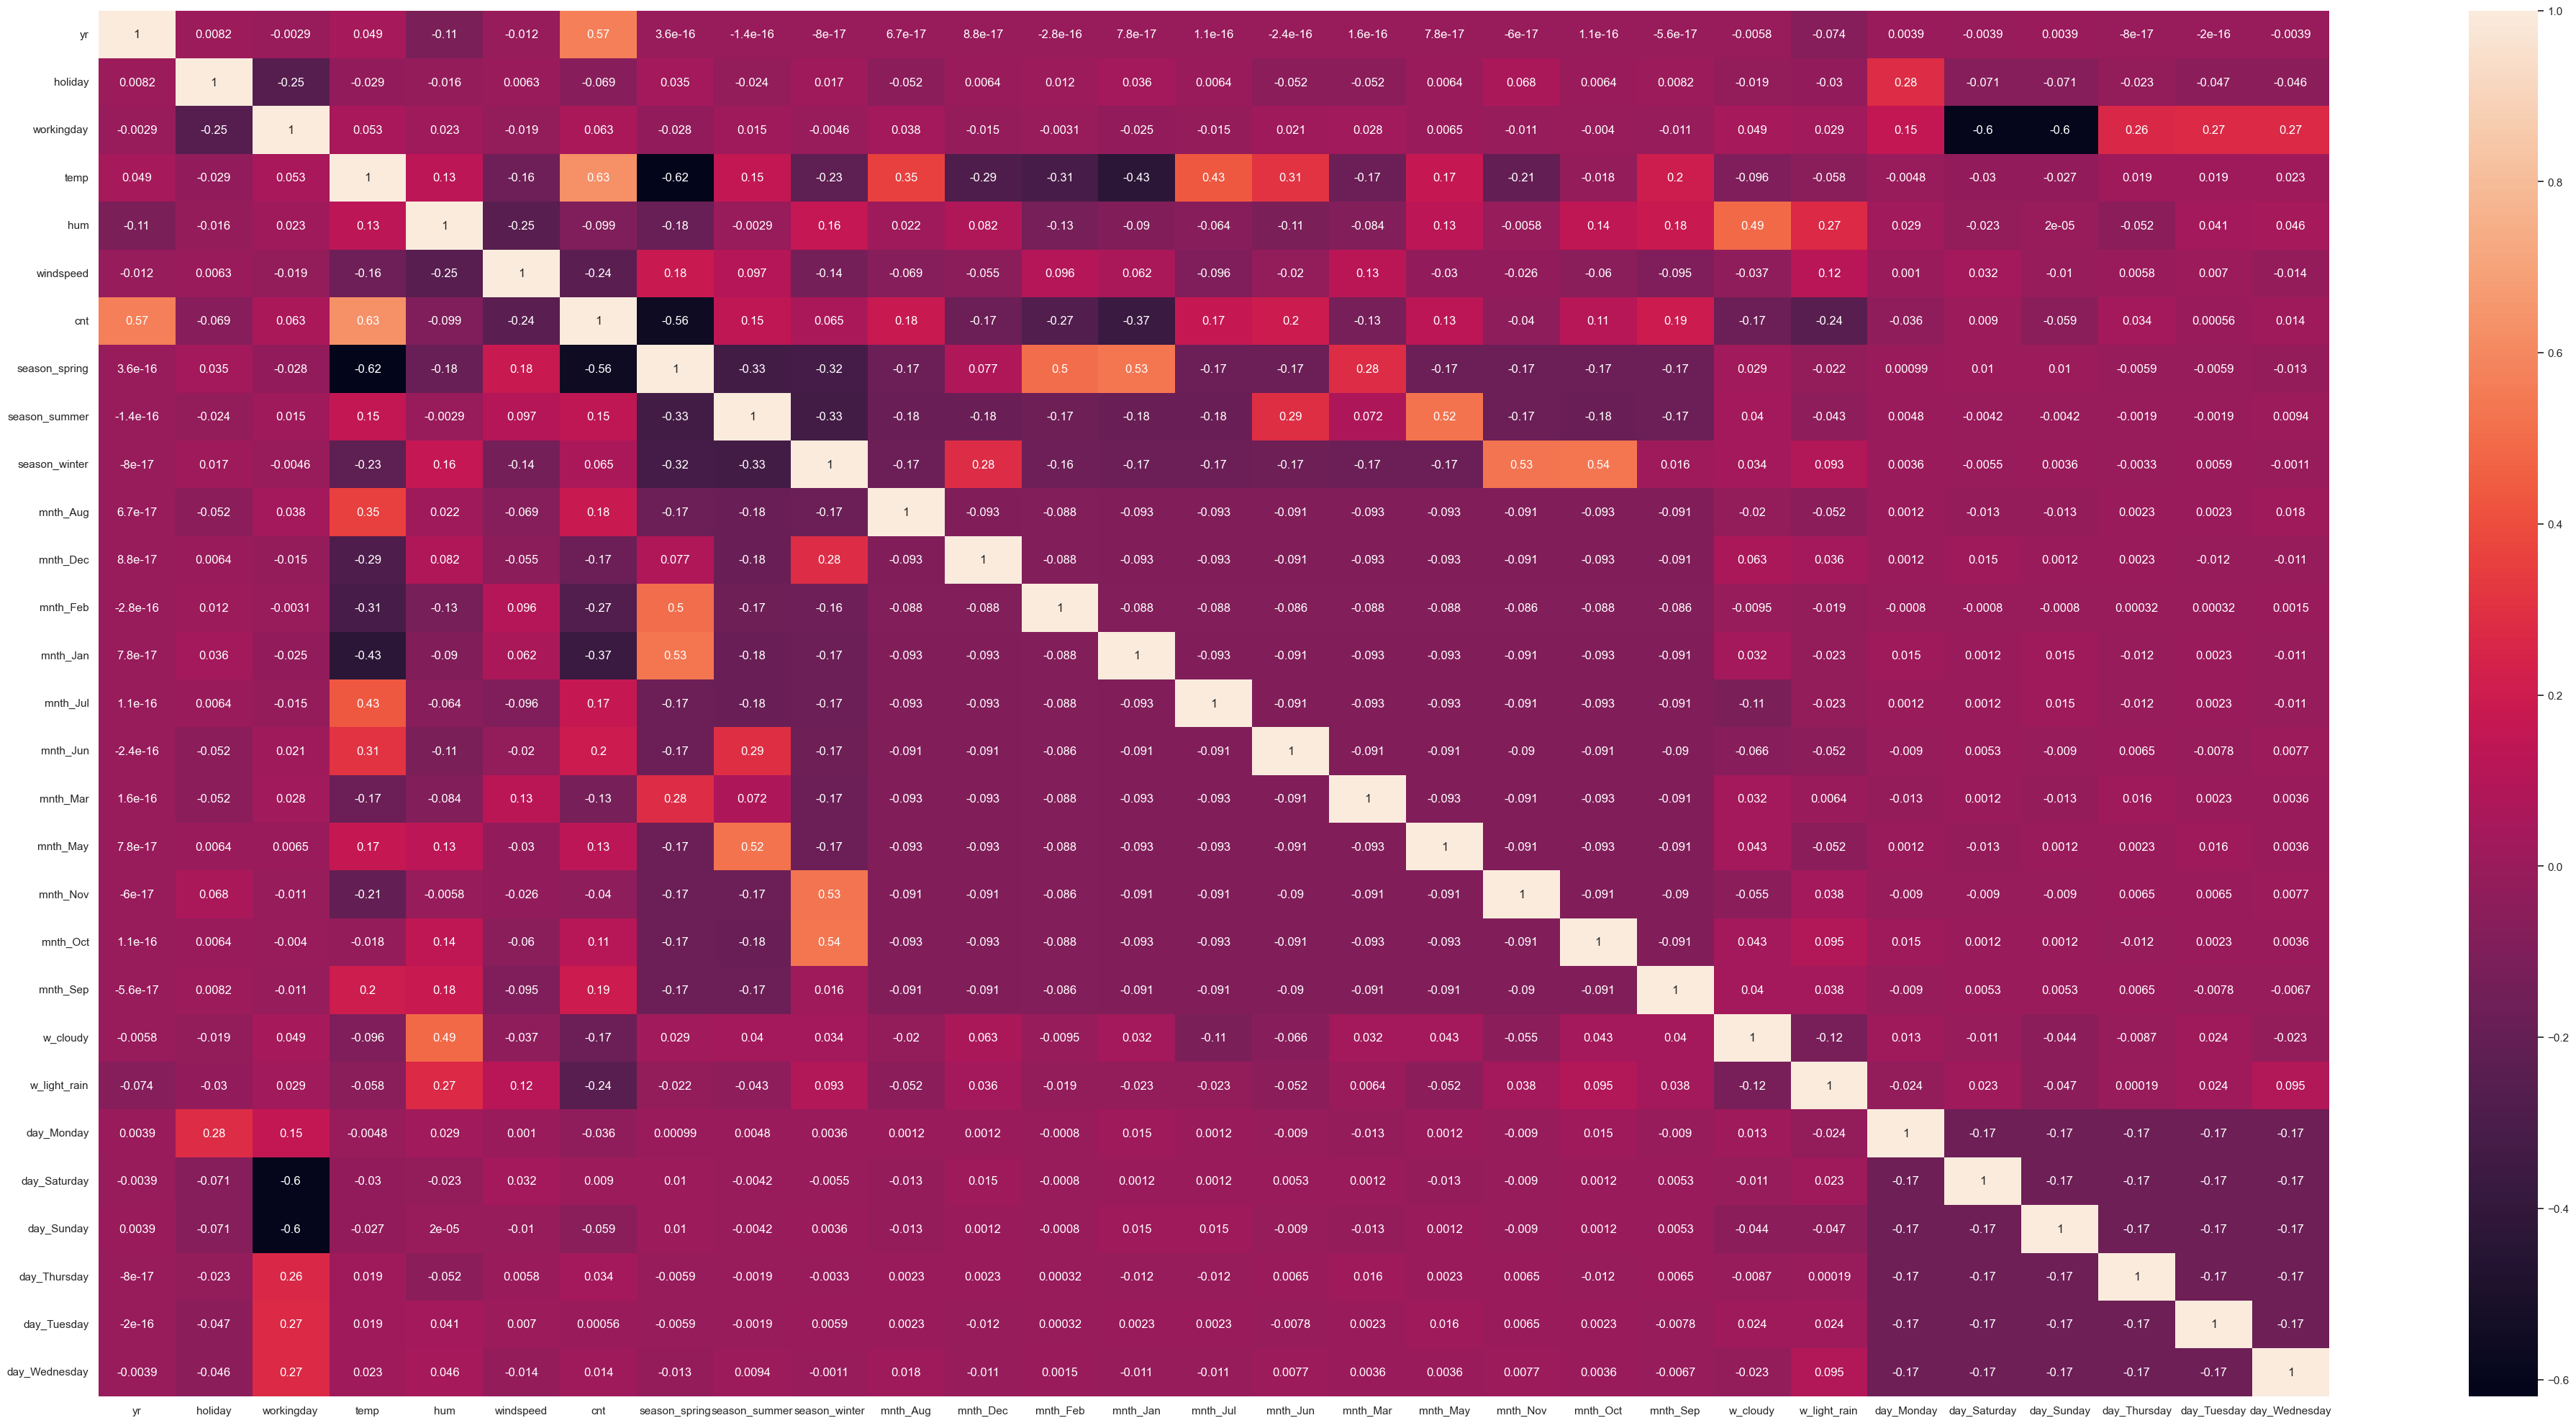

In [122]:
plt.figure(figsize=(50,25))
sns.heatmap(data=df_with_dummies.corr(), annot=True)
plt.show()

In [124]:
# cnt has higher correlation with `temp` and `yr`
# `hum` with `w_cloudy`
# negative corr between `season_spring` and `cnt`

# Train/Test Data Preparation for model building

In [127]:
df_train, df_test = train_test_split(df_with_dummies, train_size=0.7, random_state=100)
print("train data = ", df_train.shape,"\ntest_data = ",df_test.shape)

train data =  (510, 29) 
test_data =  (220, 29)


## Scaling (MinMax)

In [130]:
# before scaling
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,w_cloudy,w_light_rain,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
576,1,0,1,29.246653,70.4167,11.083475,7216,0,0,0,...,0,0,0,0,0,0,0,0,1,0
426,1,0,0,16.980847,62.1250,10.792293,4066,1,0,0,...,0,0,1,0,0,1,0,0,0,0
728,1,0,0,10.489153,48.3333,23.500518,1796,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,15.443347,48.9583,8.708325,4220,0,1,0,...,0,0,1,0,0,1,0,0,0,0
111,0,0,1,13.803347,72.9583,14.707907,1683,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [132]:
df_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'w_cloudy',
       'w_light_rain', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday'],
      dtype='object')

In [134]:
# Apply scaler() to all columns except boolean and dummy variables
scaler = MinMaxScaler()
num_vars = ['temp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [136]:
# after scaling
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,w_cloudy,w_light_rain,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,0,0,1,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,0,0,1,0,0,0,0
728,1,0,0,0.245101,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,0,0,1,0,0,0,0
111,0,0,1,0.345824,0.751824,0.380981,0.191095,0,1,0,...,0,0,1,0,0,0,0,0,0,0


### Construct Target variable and predictor variables

In [139]:
y_train = df_train.pop('cnt')
X_train = df_train

# Build Model

## Using LinearRegression() from SciKit Learn

### RFE

#### Recursive Feature Elimination

In [145]:
# Running RFE with output number of variables as 15
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator=lm,n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [147]:
# List of features selected
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 8),
 ('season_winter', False, 12),
 ('mnth_Aug', False, 3),
 ('mnth_Dec', False, 10),
 ('mnth_Feb', False, 2),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 4),
 ('mnth_Mar', False, 9),
 ('mnth_May', False, 14),
 ('mnth_Nov', False, 6),
 ('mnth_Oct', True, 1),
 ('mnth_Sep', True, 1),
 ('w_cloudy', True, 1),
 ('w_light_rain', True, 1),
 ('day_Monday', False, 5),
 ('day_Saturday', True, 1),
 ('day_Sunday', True, 1),
 ('day_Thursday', False, 13),
 ('day_Tuesday', False, 7),
 ('day_Wednesday', False, 11)]

In [149]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'mnth_Jan', 'mnth_Jul', 'mnth_Oct', 'mnth_Sep',
       'w_cloudy', 'w_light_rain', 'day_Saturday', 'day_Sunday'],
      dtype='object')

### Utility functions to build model and check VIF

In [152]:
#Function to build LR model
def lr_model(y_train_set, X_train_set):
    X_train_sm = sm.add_constant(X_train_set)
    lm = sm.OLS(y_train_set, X_train_sm).fit()
    print(lm.summary())
    return lm

In [154]:
#Function to calculate VIF
def get_vif(X_train_set):
    vif = pd.DataFrame()
    # X_train_vif_check = X_train_set.drop(columns="const", axis=1)
    X_train_vif_check = X_train_set
    vif["Columns"] = X_train_vif_check.columns
    vif["VIF"] = [variance_inflation_factor(X_train_vif_check.values, i) for i in range(X_train_vif_check.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    vif = vif.sort_values(by = "VIF", ascending=False)
    print(vif)
    return vif

In [156]:
X_train_rfe = X_train[col]

In [158]:
X_train_rfe.head()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,mnth_Jan,mnth_Jul,mnth_Oct,mnth_Sep,w_cloudy,w_light_rain,day_Saturday,day_Sunday
576,1,0,1,0.815169,0.725633,0.264686,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,1,0,0,0,0,1,0,1,0
728,1,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,0,1
482,1,0,0,0.395666,0.504508,0.188475,0,0,0,0,0,1,0,1,0
111,0,0,1,0.345824,0.751824,0.380981,0,0,0,0,0,1,0,0,0


#### Iteration 1

In [161]:
lm = lr_model(y_train_set=y_train, X_train_set=X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.3
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          8.67e-190
Time:                        14:01:17   Log-Likelihood:                 513.76
No. Observations:                 510   AIC:                            -997.5
Df Residuals:                     495   BIC:                            -934.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2876      0.024     12.140

In [163]:
vif = get_vif(X_train_rfe)

          Columns    VIF
2      workingday  36.54
13   day_Saturday   8.91
14     day_Sunday   8.69
1         holiday   2.33
3            temp   2.20
6   season_spring   2.01
4             hum   1.85
11       w_cloudy   1.55
7        mnth_Jan   1.52
8        mnth_Jul   1.31
12   w_light_rain   1.26
5       windspeed   1.18
10       mnth_Sep   1.13
9        mnth_Oct   1.12
0              yr   1.03


In [165]:
# `holiday` has higher p-value. Lets drop that variable
X_train_rfe = X_train_rfe.drop(columns="holiday", axis=1)

#### Iteration 2

In [168]:
lm = lr_model(y_train_set=y_train, X_train_set=X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.3
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          8.67e-190
Time:                        14:01:19   Log-Likelihood:                 513.76
No. Observations:                 510   AIC:                            -997.5
Df Residuals:                     495   BIC:                            -934.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2957      0.038      7.793

In [170]:
# Removing `holiday` hasn't impacted the Adj R-squared value.

In [172]:
vif = get_vif(X_train_rfe)

          Columns    VIF
3             hum  25.11
1      workingday  16.50
2            temp  13.63
4       windspeed   4.54
12   day_Saturday   4.44
13     day_Sunday   4.34
5   season_spring   2.49
10       w_cloudy   2.19
0              yr   2.07
6        mnth_Jan   1.66
7        mnth_Jul   1.42
11   w_light_rain   1.24
8        mnth_Oct   1.23
9        mnth_Sep   1.23


In [174]:
# `day_Sunday` has higher p-value. Lets drop that variable
X_train_rfe = X_train_rfe.drop(columns="day_Sunday", axis=1)

#### Iteration 3

In [177]:
lm = lr_model(y_train_set=y_train, X_train_set=X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.7
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          3.68e-190
Time:                        14:01:22   Log-Likelihood:                 511.87
No. Observations:                 510   AIC:                            -995.7
Df Residuals:                     496   BIC:                            -936.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3387      0.031     11.046

In [179]:
# Removing `day_Sunday` hasn't impacted the Adj R-squared value.
# All the p-values are less than 0.05

In [181]:
vif = get_vif(X_train_rfe)

          Columns    VIF
3             hum  17.24
2            temp  12.88
1      workingday   4.64
4       windspeed   4.09
5   season_spring   2.41
10       w_cloudy   2.11
0              yr   2.05
12   day_Saturday   1.81
6        mnth_Jan   1.65
7        mnth_Jul   1.42
8        mnth_Oct   1.23
9        mnth_Sep   1.22
11   w_light_rain   1.21


In [183]:
# `hum` has high VIF. Lets drop that variable
X_train_rfe = X_train_rfe.drop(columns="hum", axis=1)

#### Iteration 4

In [186]:
lm = lr_model(y_train_set=y_train, X_train_set=X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     216.7
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          1.16e-188
Time:                        14:01:24   Log-Likelihood:                 505.51
No. Observations:                 510   AIC:                            -985.0
Df Residuals:                     497   BIC:                            -930.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2578      0.021     12.466

In [188]:
# Removing `hum` hasn't impacted the Adj R-squared value significantly.
# All the p-values are less than 0.05

In [190]:
vif = get_vif(X_train_rfe)

          Columns   VIF
2            temp  6.63
1      workingday  4.34
3       windspeed  4.02
4   season_spring  2.21
0              yr  2.05
11   day_Saturday  1.75
5        mnth_Jan  1.61
9        w_cloudy  1.55
6        mnth_Jul  1.37
8        mnth_Sep  1.22
7        mnth_Oct  1.16
10   w_light_rain  1.10


In [192]:
# `temp` has high VIF. Lets drop that variable
X_train_rfe = X_train_rfe.drop(columns="temp", axis=1)

#### Iteration 5

In [195]:
lm = lr_model(y_train_set=y_train, X_train_set=X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     151.9
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          3.09e-151
Time:                        14:01:29   Log-Likelihood:                 414.04
No. Observations:                 510   AIC:                            -804.1
Df Residuals:                     498   BIC:                            -753.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4791      0.017     28.387

In [197]:
# Removing `temp` has significantly affected the adj R-squared value.
# Get the column back

X_train_rfe["temp"] = X_train["temp"]

In [199]:
lm = lr_model(y_train_set=y_train, X_train_set=X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     216.7
Date:                Wed, 25 Dec 2024   Prob (F-statistic):          1.16e-188
Time:                        14:01:30   Log-Likelihood:                 505.51
No. Observations:                 510   AIC:                            -985.0
Df Residuals:                     497   BIC:                            -930.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2578      0.021     12.466

In [201]:
vif = get_vif(X_train_rfe)

          Columns   VIF
11           temp  6.63
1      workingday  4.34
2       windspeed  4.02
3   season_spring  2.21
0              yr  2.05
10   day_Saturday  1.75
4        mnth_Jan  1.61
8        w_cloudy  1.55
5        mnth_Jul  1.37
7        mnth_Sep  1.22
6        mnth_Oct  1.16
9    w_light_rain  1.10


In [203]:
# Looks like this is the final model

In [205]:
# I have experimented with different combination of RFE variables and random state values.

# random-state - 42 rfe 15 (r-sqaure - 0.81 - it had fewer fields)
# random-state - 100 rfe 15 (r-sqaure - 0.814 - temp, workingday, windspeed, season_spring, yr, day_Saturday, mnth_Jan, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, w_light_rain)
# random-state - 100, rfe 10 (r-sqaure - 0.779 - temp, workingday, windspeed, season_spring, yr, day_Saturday, mnth_Jan, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, w_light_rain)
# random-state - 100, rfe 18 (r-sqaure - 0.814 - temp, workingday, windspeed, season_spring, yr, day_Saturday, mnth_Jan, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, w_light_rain)
# random-state - 63 rfe 15 (r-sqaure - 0.805 - temp, workingday, windspeed, season_spring, season_winter, yr, day_Saturday, mnth_Nov, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, w_light_rain)

# Best is random-state - 100, rfe 15 (r-sqaure - 0.814 - temp, workingday, windspeed, season_spring, yr, day_Saturday, mnth_Jan, w_cloudy, mnth_Jul, mnth_Sep, mnth_Oct, w_light_rain)

### Residual Analysis of Train data

In [208]:
X_train_rfe.head()

,yr,workingday,windspeed,season_spring,mnth_Jan,mnth_Jul,mnth_Oct,mnth_Sep,w_cloudy,w_light_rain,day_Saturday,temp
576,1,1,0.264686,0,0,1,0,0,0,0,0,0.815169
426,1,0,0.255342,1,0,0,0,0,1,0,1,0.442393
728,1,0,0.663106,1,0,0,0,0,0,0,0,0.245101
482,1,0,0.188475,0,0,0,0,0,1,0,1,0.395666
111,0,1,0.380981,0,0,0,0,0,1,0,0,0.345824


In [210]:
y_train_pred = lm.predict(sm.add_constant(X_train_rfe))

Text(0.5, 12.44444444444443, 'Errors')

<Figure size 640x480 with 0 Axes>

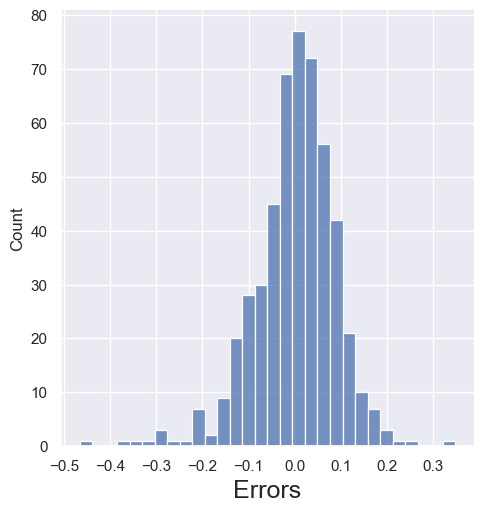

In [212]:
fig = plt.figure()
sns.displot((y_train - y_train_pred), bins = 30)
fig.suptitle("Error Terms", fontsize = 20)
plt.xlabel("Errors", fontsize = 18)

In [214]:
# the errors are centred at 0

Text(0, 0.5, 'y_train_pred')

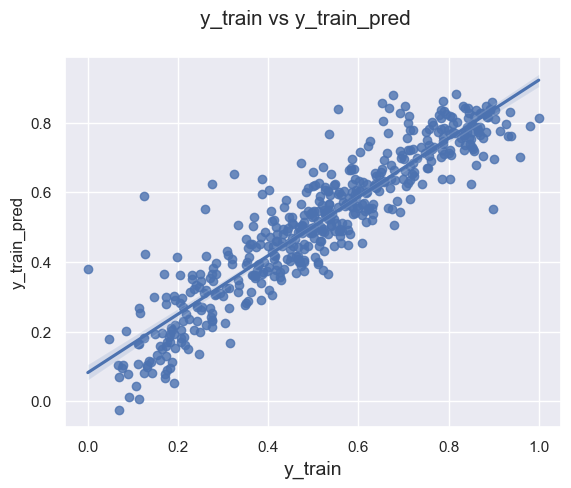

In [216]:
fig = plt.figure()
sns.regplot(x=y_train, y=y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize = 15)             
plt.xlabel('y_train', fontsize = 14)                          
plt.ylabel('y_train_pred', fontsize = 12) 

In [218]:
# The points are closer to the fit line.

### Homoscedasticity

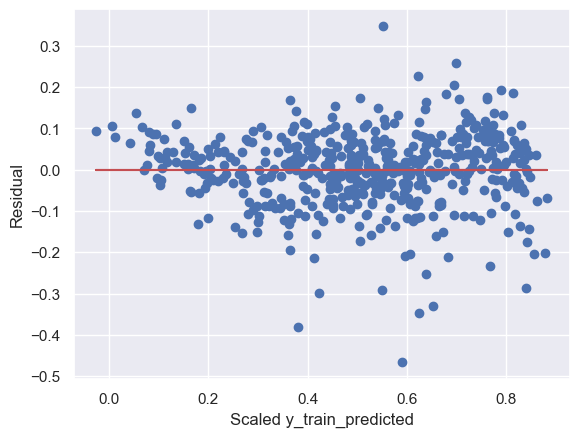

In [221]:
residual = y_train - y_train_pred
plt.scatter(y_train_pred,residual)
plt.plot(y_train_pred,(y_train - y_train), 'r')
plt.xlabel('Scaled y_train_predicted')
plt.ylabel('Residual')
plt.show()

In [223]:
# The above graphs validates the assumption of linear regression where
# 1. The errors are normally distributed and peaked around 0
# 2. There is no clear pattern of residuals vs y_train validating Homoscedasticity

## Predictions

In [226]:
# Check num_vars
num_vars

['temp', 'hum', 'windspeed', 'cnt']

### Scaling test data

In [229]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [231]:
df_test.shape

(220, 29)

In [233]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,w_cloudy,w_light_rain,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
184,0,1,0,0.831783,0.657364,0.084219,0.692706,0,0,0,...,0,0,1,0,1,0,0,0,0,0
535,1,0,1,0.901354,0.610133,0.153728,0.712034,0,1,0,...,0,0,0,0,0,0,0,0,0,1
299,0,0,1,0.511964,0.837699,0.334206,0.303382,0,0,1,...,1,0,1,0,0,0,0,1,0,0
221,0,0,1,0.881625,0.437098,0.339570,0.547400,0,0,0,...,0,0,0,0,0,0,0,0,0,1
152,0,0,1,0.817246,0.314298,0.537414,0.569029,0,1,0,...,0,0,0,0,0,0,0,1,0,0


### Construct Target variable and predictor variables for test data

In [236]:
y_test = df_test.pop("cnt")
X_test = df_test

### Predict test data

In [239]:
X_test_rfe = X_test[X_train_rfe.columns]
X_test_rfe = sm.add_constant(X_test_rfe)

In [241]:
y_pred = lm.predict(X_test_rfe)

## Model Evaluation

In [244]:
# test data
r2_score(y_true=y_test, y_pred=y_pred)

0.8148601987414753

In [248]:
# train data
r2_score(y_true=y_train, y_pred=y_train_pred)

0.8395602436490203

In [250]:
lm.params

const            0.257838
yr               0.236768
workingday       0.054584
windspeed       -0.159066
season_spring   -0.121434
mnth_Jan        -0.051827
mnth_Jul        -0.061028
mnth_Oct         0.057246
mnth_Sep         0.061751
w_cloudy        -0.081629
w_light_rain    -0.298337
day_Saturday     0.066623
temp             0.381692
dtype: float64

Text(0, 0.5, 'y_pred')

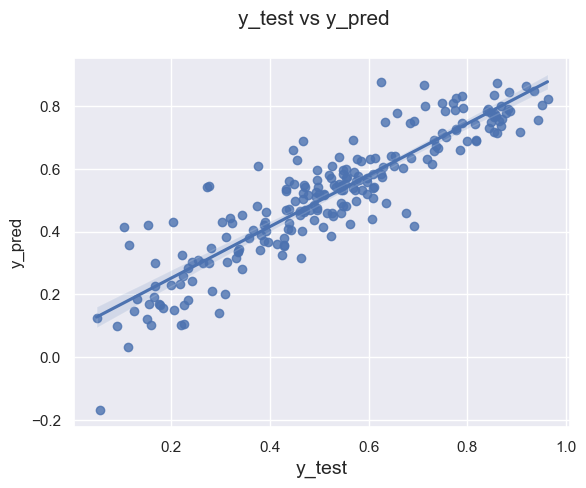

In [252]:
fig = plt.figure()
sns.regplot(x=y_test, y=y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 15)             
plt.xlabel('y_test', fontsize = 14)                          
plt.ylabel('y_pred', fontsize = 12) 

In [254]:
# r2_score for train data = 0.839
# r2_score for test data = 0.814

# final linear equation is
# cnt = 0.257838 + (0.381692)*temp - (0.298337)*w_light_rain + (0.236768)*yr - (0.159066)*windspeed - (0.121434)* season_spring
#        - (0.081629)*w_cloudy + (0.066623)* day_Saturday + (0.061751)*mnth_Sept - (0.061028)*mnth_Jul + (0.057246)* mnth_Oct 
#        + (0.051827)*workingday - (0.051827)* mnth_Jan

### Following factors determine the demand for bikes yr, workingday, windspeed, season_spring, mnth_Jan, mnth_Jul, mnth_Oct, mnth_Sep, w_cloudy, w_light_rain, day_Saturday, temp.

In [ ]:
### Temp, yr and w_light_rain has more impact on the final impact than other 